## Observations and Insights

## Dependencies and starter code

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import requests

# Study data files
mouse_metadata = "data/Mouse_metadata.csv"
study_results = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata)
study_results = pd.read_csv(study_results)

# Combine the data into a single dataset
study = pd.merge(study_results, mouse_metadata, on=['Mouse ID'], how='inner')

## Summary statistics

In [2]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# create a new DataFrame
tv_summary = pd.DataFrame()

# generate `Tumor Volume` average and store
tv_summary['Mean'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].mean()

# generate `Tumor Volume` median and store
tv_summary['Median'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].median()

# generate `Tumor Volume` variance and store
tv_summary['Variance'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].var()

# generate `Tumor Volume` standard deviation and store
tv_summary['STD'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].std()

# generate `Tumore Volume` SEM and store
tv_summary['SEM'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].sem()

# style and display table
(tv_summary
           .style
           .format('{:.2f}')
           .set_caption('Summary of Tumor Volume by Treatment')
)

,Mean,Median,Variance,STD,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.85,42.35,6.51,0.51
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


## Bar plots

In [3]:
# Bar plot showing number of data points for each treatment regimen using pandas

# create dataframe grouped by treatment regimen
data_points = study.groupby('Drug Regimen')['Mouse ID'].count()

# sort the data in ascending order for best display on chart
data_points = data_points.sort_values(ascending=True)

# title to use for both plots 
title = 'Number of Trials by Drug Regimen'

In [8]:
data_points

Drug Regimen
Propriva     161
Ceftamin     178
Infubinol    178
Placebo      181
Stelasyn     181
Zoniferol    182
Naftisol     186
Ketapril     188
Ramicane     228
Capomulin    230
Name: Mouse ID, dtype: int64

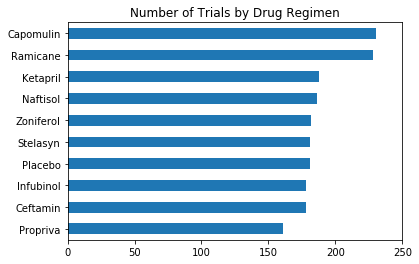

In [4]:
# generate a horizontal bar plot
data_points.plot(kind='barh', title=title, xlim=(0,250))

# clear y axis label
plt.ylabel('')

# show plot
plt.show()

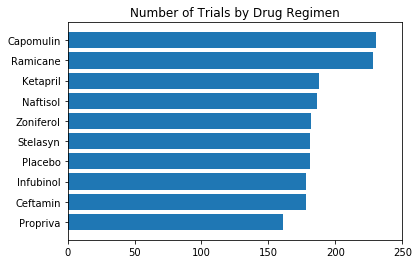

In [5]:
# Generate a bar plot showing number of data points for each treatment regimen using pyplot

# generate horizontal bar plot
plt.barh(y=data_points.index, width=data_points)

# set plot title
plt.title(title)

# set x limits
plt.xlim(0, 250)

# set axis labels
plt.ylabel('')

# show plot
plt.show()

## Pie plots

In [6]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

# generate DataFrame from grouped by `Sex` value counts
genders = pd.DataFrame(study['Sex'].value_counts())
title = 'Distribution by Sex'

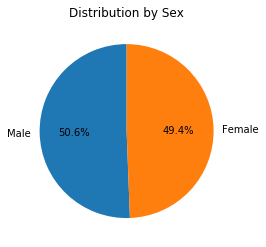

In [7]:
# generate a pie plot using pandas
genders.plot(kind='pie', y='Sex', legend=False, startangle=90, autopct='%1.1f%%', title=title)

# clear y axis label
plt.ylabel('')

# show plot
plt.show()

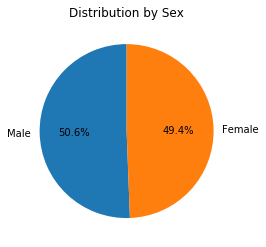

In [9]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(genders, labels=genders.index, autopct='%1.1f%%', startangle=90)

# set title of plot
plt.title(title)

# clear y axis label
plt.ylabel('')

# show plot
plt.show()

## Quartiles, outliers and boxplots

In [10]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers. 

#promising = list(data_points.tail(4).sort_values(ascending=False).index)
# create list of the most promising trement regimens
promising = list(study.groupby('Drug Regimen')['Tumor Volume (mm3)'].min().sort_values().reset_index().head(4)['Drug Regimen'])

# condition for retrieving all rows matching promising treatments
cond = (study['Drug Regimen'].isin(promising))

# group by `Mouse ID` and `Drug Regimen` to get the maximum `Timepoint` for each mouse
temp_df = study[cond].groupby(['Mouse ID','Drug Regimen'], as_index=False)['Timepoint'].max()

# return a DataFrame matching the grouped DataFrame by performing an inner join 
final_tumors = study.merge(temp_df, on=['Mouse ID', 'Drug Regimen', 'Timepoint'], how='inner')


In [15]:
# calculate the quartiles
quantiles = { drug: final_tumors[final_tumors['Drug Regimen'] == drug]['Tumor Volume (mm3)'].quantile([0.25,0.5,0.75,1.0]) for drug in promising }

quartiles = pd.DataFrame(quantiles)

iqrs = []
lower_bounds = []
upper_bounds = []

for column in quartiles.columns:
    lowerq = float(quartiles[column][quartiles.index == 0.25].values)
    upperq = float(quartiles[column][quartiles.index == 0.75].values)
    iqr = upperq - lowerq
    iqrs.append(iqr)
    lower_bounds.append(lowerq - (1.5*iqr))
    upper_bounds.append(upperq + (1.5*iqr))

quartiles.loc['IQR'] = iqrs
quartiles.loc['lower_bound'] = lower_bounds
quartiles.loc['upper_bound'] = upper_bounds

(quartiles.style
          .format('{:.2f}')
          .set_caption('Tumor Volume quartiles, outliers & IQR by Regimen'))




,Ramicane,Capomulin,Infubinol,Ceftamin
0.25,31.56,32.38,54.05,48.72
0.5,36.56,38.13,60.17,59.85
0.75,40.66,40.16,65.53,64.30
1.0,45.22,47.69,72.23,68.92
IQR,9.10,7.78,11.48,15.58
lower_bound,17.91,20.70,36.83,25.36
upper_bound,54.31,51.83,82.74,87.67


In [ ]:
for drug in promising:
    print(final_tumors[(final_tumors['Drug Regimen']==drug) & (final_tumors['Tumor Volume (mm3)'] < float(quartiles[quartiles.index == 'lower_bound'][drug].values))])

In [ ]:
for drug in promising:
    print(final_tumors[(final_tumors['Drug Regimen']==drug) & (final_tumors['Tumor Volume (mm3)'] > float(quartiles[quartiles.index == 'upper_bound'][drug].values))])

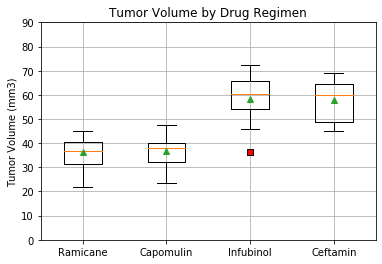

In [16]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

# create list of `Tumor Volume` values for each drug regimen
plots = [ final_tumors[final_tumors['Drug Regimen'] == drug]['Tumor Volume (mm3)'] for drug in promising]

# define a colors and styles for outliers
green_diamond = dict(markerfacecolor='g', marker='D')
red_square = dict(markerfacecolor='r', marker='s')

# create a box plot
plt.boxplot(plots, labels=promising, showmeans=True, showfliers=True, flierprops=red_square)

# set title of box plot
plt.title('Tumor Volume by Drug Regimen')

# set vertical label
plt.ylabel('Tumor Volume (mm3)')

# set vertical limits
plt.ylim(0,90)

# show grid
plt.grid()

# show chart
plt.show()

## Line and scatter plots

In [17]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin

# condition 1: where `Drug Regimen` is `Capomulin`
cond1 = (study['Drug Regimen'] == 'Capomulin')

# condition 2: where `Mouse ID` is `s185`
cond2 = (study['Mouse ID'] == 's185')

# combine conditions with AND
conds = (cond1 & cond2)

# create new dataframe matching conditions
mouse_df = study[conds].set_index('Mouse ID')

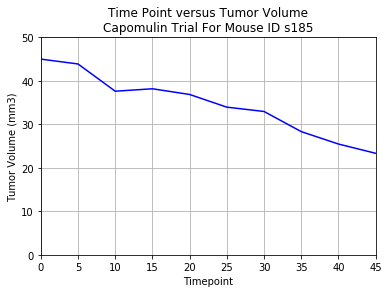

In [18]:
# generate a line plot for `Mouse ID` is `s185`
mouse_df.plot(kind='line',x='Timepoint',y='Tumor Volume (mm3)',title='Time Point versus Tumor Volume\nCapomulin Trial For Mouse ID s185', legend=False, grid=True, ylim=(0,50), xlim=(0,45), color='blue')

# set axis labels
plt.ylabel('Tumor Volume (mm3)')
plt.xlabel('Timepoint')

# show plot
plt.show()

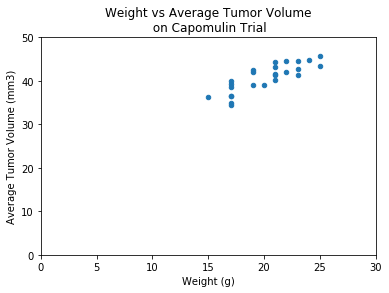

In [19]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen

# condition 1: where `Drug Regimen` is `Capomulin`
cond1 = (study['Drug Regimen'] == 'Capomulin')

# create new empty DataFrame
weights = pd.DataFrame()

# retrieve the weight for each `Mouse ID`
weights['Weight (g)'] = study[cond1].groupby('Mouse ID')['Weight (g)'].unique().astype(int)

# calculate the average of `Tumor Volume` for each `Mouse ID`
weights['Average Tumor Volume (mm3)'] = study[cond1].groupby('Mouse ID')['Tumor Volume (mm3)'].mean()

# set title variable
title = 'Weight vs Average Tumor Volume\n on Capomulin Trial'

# generate a scatter plot
weights.plot(kind='scatter', x='Weight (g)', y='Average Tumor Volume (mm3)', title=title, xlim=(0,30), ylim=(0,50))

# show plot
plt.show()

In [20]:
# Calculate the correlation coefficient for mouse weight and average tumor volume for the Capomulin regimen

# set x_values from mouse `Weight`
x_values = weights['Weight (g)']

# set y_values from `Average Tumor Volume`
y_values = weights['Average Tumor Volume (mm3)']

# calculate the correlation coefficient
r = st.pearsonr(x_values, y_values)[0]

# display the correlation coefficient
print(f"The correlation coefficient between\nweight and average tumor volume is {round(r, 2)}")

The correlation coefficient between
weight and average tumor volume is 0.84


In [21]:
# Calculate the linear regression model for mouse weight and average tumor volume for the Capomulin regimen

# calculate the linear regression model
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# calculate linear regression values
regress_values = x_values * slope + intercept

# generate linear equation
line_eq = "y = " + str(round(slope,1)) + "x + " + str(round(intercept,1))

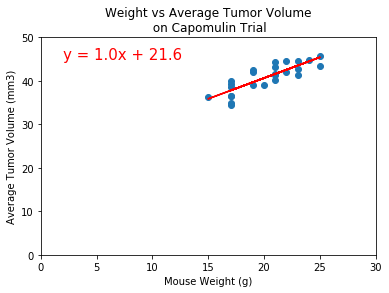

In [22]:
# generate scatter plot
plt.scatter(x_values, y_values)

# add linear regression line to plot
plt.plot(x_values, regress_values, 'r')

# add linear regression equation to plot
plt.annotate(line_eq, (2,45), fontsize=15, color='red')

# set plot title
plt.title(title)

# add label and limits to x axis
plt.xlabel('Mouse Weight (g)')
plt.xlim(0,30)

# add label and limits to y axis
plt.ylabel('Average Tumor Volume (mm3)')
plt.ylim(0,50)

# show plot
plt.show()